# A model for the effect of Degree of Linear Polarization on Dung Beetle Orientation Accuracy
---

## Details

&ensp;AUTHOR:&emsp;   James Foster &emsp; 2025 03 26

MODIFIED:&emsp; James Foster &emsp; 2025 03 28

DESCRIPTION:&emsp; Fit a hierarchical maximum-likelihood von Mises to dung beetle exit angles under a rotatable polarized light stimulus.
Modified from [beetles.ipynb](https://github.com/jgraving/unwrap/notebooks/)

            
INPUTS:&emsp;   `'DLdata201611.csv'`
            
OUTPUTS:&emsp;  Plots and test statistics

CHANGES: 
- Added 0.32 condition to positive control
- Changed prior on individual mu to Normal
- Made categorical DoLP model
- Made linear DoLP modela
- Added model comparison

REFERENCES:
- Foster, J.J., $et~al$.  (2019). 
Orienting to polarized light at night – matching lunar skylight to performance in a nocturnal beetle.
Journal of Experimental Biology 222, jeb188532. 
DOI:[10.1242/jeb.188532](https://doi.org/10.1242/jeb.188532)

- Sayin S, ... Graving JM, $et~al$. (2025)
The behavioral mechanisms governing collective motion in swarming locusts.
Science 387,995-1000
DOI:[10.1126/science.adq7832](https://doi.org/10.1126/science.adq7832)

- Graving JM & Foster JJ (in preparation)
Unwrapping Circular Statistics: Bayesian Linear Models for Circular Data

---
# TODO
>- Try looser priors for max polarization condition +
>- Compare circular uniform and unimodal priors +
>- Combine DoLP 0.99 and 0.32 conditions +
>- Try restrictive empirical priors +
>- Try normal priors +
>- Find appropriate priors for the 90° turn +
>- Test model with categorical DoLP +
>- Test model with linear DoLP + 
>- Test model with log10 DoLP +
>- Test model with logit DoLP +
- Reset circular effects of DoLP to categorical
- Test 2019 model
- Test bimodal model

In [ ]:
import sys
!{sys.executable} -m pip uninstall -y unwrap
!{sys.executable} -m pip install -U --no-cache git+https://github.com/jgraving/unwrap

Found existing installation: unwrap 0.0.1
Uninstalling unwrap-0.0.1:
  Successfully uninstalled unwrap-0.0.1
Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/jgraving/unwrap to c:\users\james foster\appdata\local\temp\pip-req-build-yzs3d0nq
  Resolved https://github.com/jgraving/unwrap to commit b158ec9cf3b6d06ed4c9baa721978c7a1ab1dd84
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for unwrap: filename=unwrap-0.0.1-py3-none-any.whl size=11617 sha256=d975fbd41897262af0f95d3bc704db40d6b14224b634e5238db9f97a08c8e096
  Stored in directory: C:\Users\James Foster\AppData\Local\Temp\pip-ephem-wheel-cache-2221tczn\wheels\6d\a6\84\e3cfe169b27e40b37f18ed01b9a2ce83462e4b2ccd53a02794
Successfully built unwrap


  Running command git clone --filter=blob:none --quiet https://github.com/jgraving/unwrap 'C:\Users\James Foster\AppData\Local\Temp\pip-req-build-yzs3d0nq'


# Reorganise data for modelling
The original data was in a wide format with separate columns for the angle observed in trials 1 and 2,
as well as for the different conditions in trials 1 and 2.

Here we separate them, convert condition names to condition features, and convert angles from degrees to radians.

In [1]:
import pandas as pd
import numpy as np
from unwrap.link.numpy import shifted_modulo

# Load the file
file_path = 'DLdata201611.csv'
df_raw = pd.read_csv(file_path, sep=',')
#Columns
#night	trial1	trial2	cond1	cond2	deg.of.pol	Beetle

# Data is in wide format, convert from wide to long
df = pd.wide_to_long(df_raw,
                          stubnames= ['trial','cond'], #find columns starting with these labels
                          i = 'Beetle', #organise by beetle
                          j = 'Trial') #assign trial to a new column called "Trial"
#Convert Beetle and Trial from indices to column names
df = df.reset_index(level = ['Beetle', 'Trial']) #After conversion saves as separate index columns
# #Rename variables for BAMBI
df = df.rename(columns={'trial': 'deg_angle'}) #save output from each trial column as the angle
df = df.rename(columns={'deg.of.pol': 'DoLP'}) #capitalise DoLP
df = df.rename(columns={'night': 'Night'}) #Captitalise
df = df.rename(columns={'Beetle': 'Individual'}) #More specific name NB very likely some are the same indiv multiple times

# Specify circular data
df['RadAngle'] = np.deg2rad(df['deg_angle']) #convert to radians
# Normalize the heading radians to be between -pi and pi
df['RadAngle'] = df['RadAngle'].apply(lambda x: shifted_modulo(x) if pd.notnull(x) else x)

# # Specify condition types by rotation angle
df['PolAngle'] = df['cond'].apply(
    lambda x: 
    0 if 'PolNorth' in x else 
     0 if 'UnpolNorth' in x else 90)
df['PolAngle_rad'] = np.deg2rad(df['PolAngle']) #convert to radians


# # Rename columns: change 'Beetle' to 'Individual'
df['Individual'] = df['Individual'].astype('category')
df['Night'] = df['Night'].astype('category')

# # Keep only the relevant columns and drop rows with missing values
df = df[['Individual', 'Trial', 'DoLP', 'PolAngle_rad', 'Night', 'RadAngle', 'deg_angle']].dropna().copy()
df.reset_index(drop=True, inplace=True)

df.head(n = 345)

Individual  Trial  DoLP  PolAngle_rad     Night  RadAngle  deg_angle
0            1      1  0.99      0.000000  20161111 -2.094395        240
1            2      1  0.02      0.000000  20161111  2.268928        130
2            3      1  0.99      1.570796  20161111  1.047198         60
3            4      1  0.02      1.570796  20161111 -0.785398        315
4            5      1  0.99      0.000000  20161111  1.570796         90
..         ...    ...   ...           ...       ...       ...        ...
340          1      2  0.99      1.570796  20161111 -1.919862        250
341          2      2  0.02      1.570796  20161111 -1.832596        255
342          3      2  0.99      0.000000  20161111  0.261799         15
343          4      2  0.02      0.000000  20161111 -2.007129        245
344          5      2  0.99      1.570796  20161111  0.349066         20

[345 rows x 7 columns]

# Inspect the data

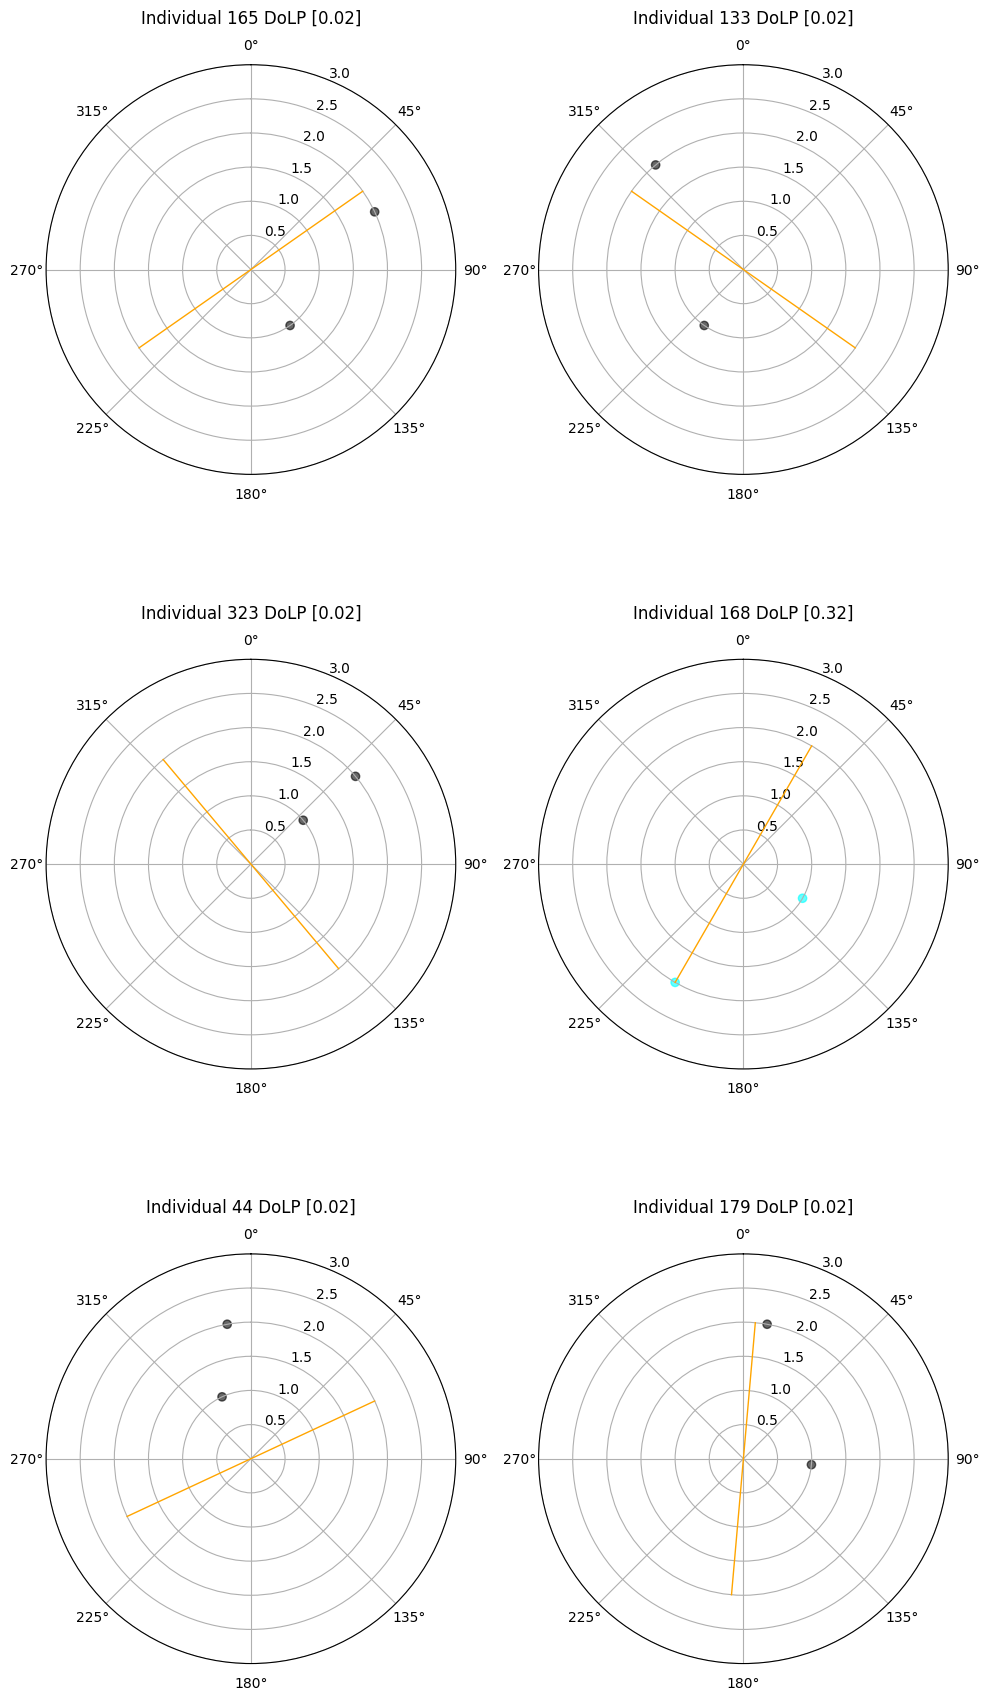

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import circmean, circstd
from matplotlib.lines import Line2D

# Helper function to compute the circular median.
def circ_median(angles):
    angles = np.sort(angles)
    diffs = np.abs(np.angle(np.exp(1j * (angles[:, None] - angles[None, :]))))
    sum_diffs = np.sum(diffs, axis=1)
    return angles[np.argmin(sum_diffs)]

# Helper function to scatter-plot data for one condition.
def plot_scatter(ax, data, angle_col, radial_col, color, label):
    if not data.empty:
        ax.scatter(data[angle_col], data[radial_col],
                   color=color, alpha=0.6, label=label)

# Get unique individual IDs.
unique_individuals = df['Individual'].unique()
unique_individuals = unique_individuals[np.random.randint(low = 0, high=340, size=6)] # just six chosen randomly

# Create a grid of polar subplots.
n_plots = len(unique_individuals)
n_rows, n_cols = ( np.intc(np.ceil(n_plots/2)) , 2  ) # Adjust grid dimensions as needed.
fig, axes = plt.subplots(n_rows, n_cols, subplot_kw={'projection': 'polar'}, figsize=(10, 18))
axes = axes.flatten()

radial_max = np.max(df['Trial'])  # Maximum radial value (maximum runs)  # Maximum radial value

# Plot for each individual.
for idx, individual in enumerate(unique_individuals):
    ax = axes[idx]
    # Set axes to geographic format (clockwise, 0° at the top)
    ax.set_theta_zero_location('N')#place 0° at the top
    ax.set_theta_direction(-1)#reverse to clockwise

    individual_data = df[df['Individual'] == individual]
    individual_data = df[df['Individual'] == individual]
    plotcol = individual_data['DoLP'].apply(
                     lambda x: 'red' if x  == 0.99 else
                                'cyan' if x == 0.32 else
                                 'blue' if x == 0.11 else
                                 'darkblue' if x == 0.04 else
                                 'black')

    # Scatter-plot data.
    plot_scatter(ax, individual_data, 'RadAngle', 'Trial', 
                 plotcol, individual_data['DoLP'])
    #Add expected axis for 2nd trial
    ax.plot(individual_data['RadAngle'].values[0]+[-np.pi/2, np.pi/2], [radial_max, radial_max], color='orange', linewidth=1)
    
    # Plot summary statistics for each condition.
    # if not individual_data.empty:
    #     plot_summary_stats(individual_data, individual_data['RadAngle'].values, radial_max, 'gray')
    
    ax.set_title(f'Individual {individual} DoLP {np.unique(individual_data['DoLP'])}', pad=30)
    ax.set_ylim(0, radial_max + 1)
    # Remove individual legends from each subplot.
    ax.legend().set_visible(False)


plt.tight_layout()
plt.show()


# Fit a circular model with individual effects but no interactions
The model needs to predict a bimodal distribution with changes of 90° between trials 

In [3]:
# import sys
# !{sys.executable} -m pip install fastprogress
# import sys
# !{sys.executable} -m pip install ipywidgets

## First test: Positive control


In [4]:
#help with progressbar on Mac?
# https://discourse.pymc.io/t/progress-bar-not-showing-in-pymc3-3-11-1/6898/4
from fastprogress import fastprogress
fastprogress.printing = lambda: True
import numpy as np
import pandas as pd
import bambi as bmb
import arviz as az
import matplotlib.pyplot as plt

from unwrap.link.bambi import LINKS
from unwrap.link.numpy import inverse_softplus
from unwrap.prior import CircularUniformPrior
# from unwrap.distributions import BimodalVonMises
from pymc import VonMises

from scipy.stats import vonmises, circstd


#1st test, doubled angles as in Foster et al., 2019
df['TwoAngle'] = df['RadAngle'].apply(lambda x: shifted_modulo(x*2) if pd.notnull(x) else x)
df.head(n = 345)
# #1st test, condition as a categorical 
df['Cond'] = df['PolAngle_rad'].astype('category')
df_max = df[df['DoLP'] > 0.90 ] #Just the maximumg polarization
# df_max = df[df['DoLP'] > 0.31 ] #20250327 add the 2nd most polarized condition to get more data to fit to

# Use MLE estimates of one condition to find good priors for individual effects (each represents one trial per animal)
condata = df[df['Cond'] == 0 ] #just the data for polarizer to the North, expect a change of +-90° (x2 = 180°) for polarizer East
vm_prior = vonmises.fit(condata["TwoAngle"], fscale=1) #MLE von Mises fit to dist of individuals
sd_prior = circstd(condata["TwoAngle"]) #Mardia SD used as estimate of normal SD

# Define the model formula with updated, capitalized variable names.
formula = bmb.Formula(
    "TwoAngle ~ Cond + (1|Individual)",
    "kappa ~ 1 + (1|Individual)",
)

# Specify priors for the model with capitalized keys and updated variable names.
#20250327 a lot of divergences and high rhats, but fixed with normal prior on individual directions
# 2 trials per individual may be insufficient to estimate individual effects in this way
priors = {
    # Fixed effects for μ:
    # "Intercept": CircularUniformPrior(), # Unbiased prior, pop mean can be in any direction
    # It is difficult to find the mean of uniformly distributed individual headings, may be better to anchor it
    # Restrictive von Mises works, but still has some convergence problems
    # "Intercept": bmb.Prior("VonMises", mu=vm_prior[1], kappa=300.0), 
    # Normal version converges smoother
    "Intercept": bmb.Prior("Normal", mu=vm_prior[1], sigma=3*np.pi/180), 
    # We expect the effect of condition to be a change of 180° (2 x 90°), most priors find this fairly well
    "Cond": bmb.Prior("Normal", mu=np.pi, sigma=90*np.pi/180), #
    # Individual-level effects for μ: #bias to high kappa appears to cause divergent transitions here
    "1|Individual": bmb.Prior(
    # In these experiments, we have no expectation that beetles would choose the same direction in their 1st trial
    # Informative prior used expecting SD close to that measured empirically
    # Using a normal distribution because that converges better
    "Normal", mu=0, sigma=bmb.Prior("StudentT", nu = 3, mu=sd_prior, sigma = 0.1) #assume the ML estimate is correct
    # "Normal", mu=0, sigma=bmb.Prior("LogNormal", mu=np.log(sd_prior), sigma=0.1) #assume the ML estimate is correct
    ),
    # Priors for the κ-model (inside the "kappa" dictionary):
    "kappa": {
        # Fixed effects for κ:
        # # Across two trials the MLE for this should range from ≈1.5–2.8
        #20250327 try higher precision to make individual mean directions easier to estimate
        "Intercept": bmb.Prior("Normal", mu=inverse_softplus(10), sigma=1.0), 
        # Individual-level effects for κ:
        "1|Individual": bmb.Prior(
            "Normal", mu=0, sigma=bmb.Prior("LogNormal", mu=np.log(0.5), sigma=0.1) #Informative prior, individual differences in concentration are small
        ),
    },
}

# Build the model using the updated formula and priors.
model = bmb.Model(
    formula,
    df_max,
    family="vonmises",
    priors=priors,
    link={"mu": LINKS["shifted_modulo"], "kappa": LINKS["softplus"]},
    center_predictors=False,
    dropna=True,
    
)

print(model)

# Fit the model.
# 4000 iterations takes approx 90s
idata = model.fit(draws= 2000,
                  tune = 2000,
                  init = 'auto',
                  progressbar=True) # 

       Formula: TwoAngle ~ Cond + (1|Individual)
                kappa ~ 1 + (1|Individual)
        Family: vonmises
          Link: mu = shifted_modulo
                kappa = softplus
  Observations: 100
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: -0.3222, sigma: 0.0524)
            Cond ~ Normal(mu: 3.1416, sigma: 1.5708)
        
        Group-level effects
            1|Individual ~ Normal(mu: 0.0, sigma: StudentT(nu: 3.0, mu: 2.3845, sigma: 0.1))
    target = kappa
        Common-level effects
            kappa_Intercept ~ Normal(mu: 10.0, sigma: 1.0)
        
        Group-level effects
            kappa_1|Individual ~ Normal(mu: 0.0, sigma: LogNormal(mu: -0.6931, sigma: 0.1))


Initializing NUTS using jitter+adapt_diag...
C:\Users\James Foster\AppData\Roaming\Python\Python312\site-packages\pytensor\link\c\cmodule.py:2959: UserWarning: PyTensor could not link to a BLAS installation. Operations that might benefit from BLAS will be severely degraded.
This usually happens when PyTensor is installed via pip. We recommend it be installed via conda/mamba/pixi instead.
Alternatively, you can use an experimental backend such as Numba or JAX that perform their own BLAS optimizations, by setting `pytensor.config.mode == 'NUMBA'` or passing `mode='NUMBA'` when compiling a PyTensor function.
For more options and details see https://pytensor.readthedocs.io/en/latest/troubleshooting.html#how-do-i-configure-test-my-blas-library
  warnings.warn(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, Cond, 1|Individual_sigma, 1|Individual_offset, kappa_Intercept, kappa_1|Individual_sigma, kappa_1|Individual_offset]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 57 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


## Check convergence heuristics

In [5]:
#check convergence heuristics
#It may not even make sense to try to converge the model without the interaction, since the mu effect  brightness depends strongly on colour
az.summary(
    idata, 
    var_names=["Intercept",
            #    "1|Individual_kappa",
               "1|Individual_sigma",
                "Cond",
                "kappa_Intercept",
               "kappa_1|Individual_sigma",
                ],
    circ_var_names=["Intercept",
                    "Cond",
                    ]
)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Intercept                -0.326  0.053  -0.424   -0.227      0.003    0.003   
1|Individual_sigma        2.366  0.120   2.124    2.586      0.010    0.007   
Cond[1.5707963267948966] -2.792  0.148  -3.053   -2.499      0.009    0.012   
kappa_Intercept           3.300  0.476   2.366    4.165      0.008    0.005   
kappa_1|Individual_sigma  0.509  0.052   0.416    0.610      0.001    0.000   

                          ess_bulk  ess_tail  r_hat  
Intercept                    154.0    4180.0   1.02  
1|Individual_sigma           169.0     478.0   1.03  
Cond[1.5707963267948966]      74.0    1556.0   1.04  
kappa_Intercept             4018.0    4057.0   1.00  
kappa_1|Individual_sigma   10014.0    5426.0   1.00

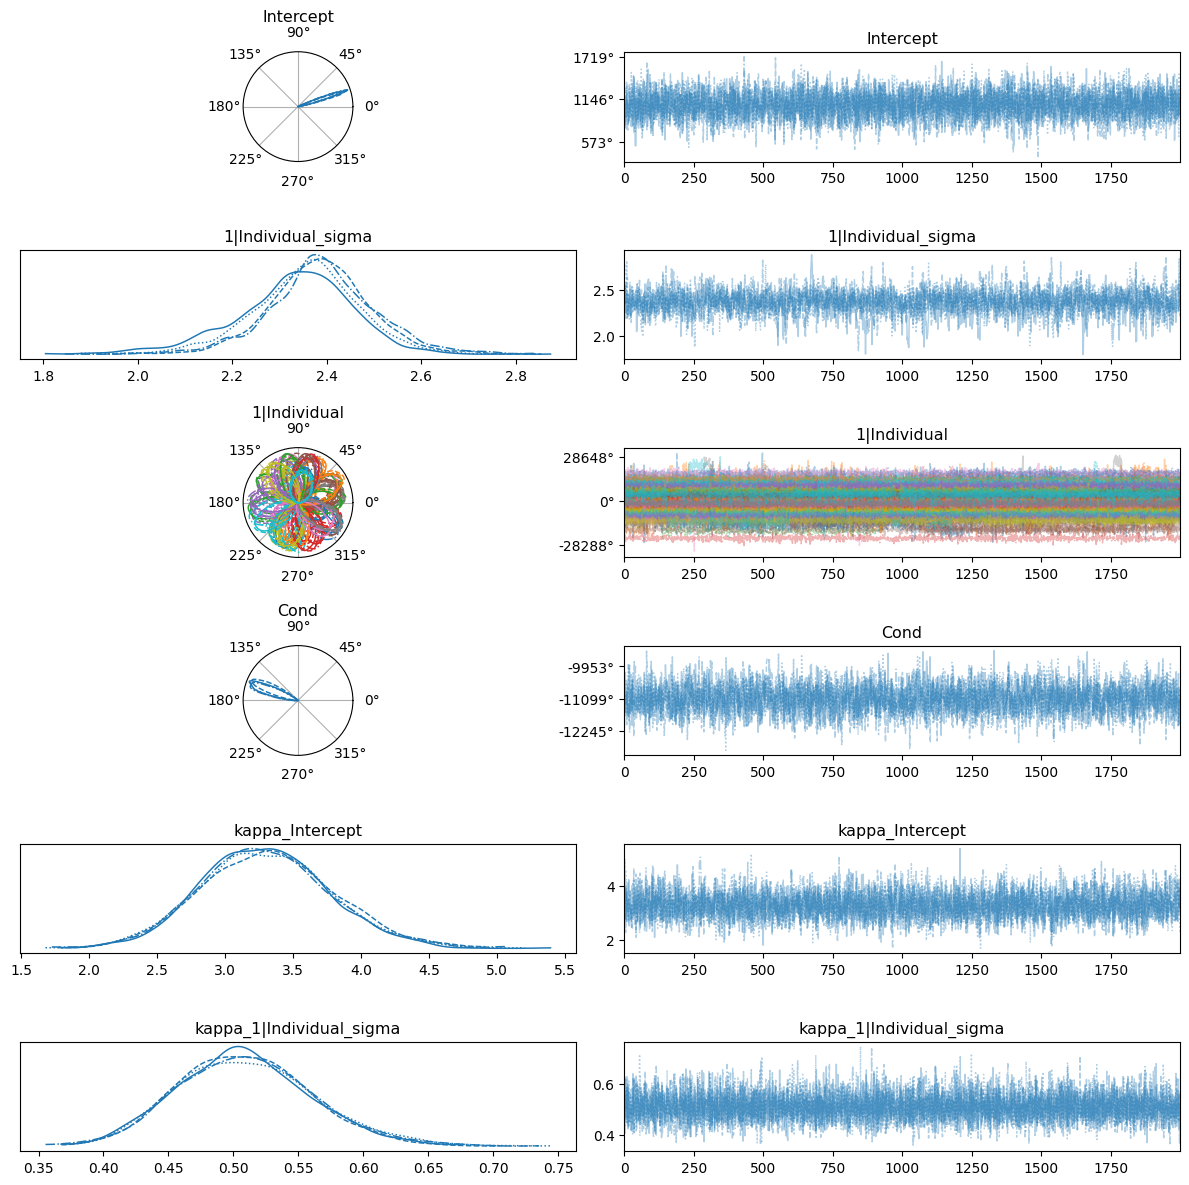

In [ ]:
varnms = ["Intercept",
            #    "1|Individual_kappa",
               "1|Individual_sigma",
               "1|Individual",
                "Cond",
                "kappa_Intercept",
               "kappa_1|Individual_sigma",
                ]
#Specify which parameters are circular
cvars = ["Intercept",
        "Cond",
        "1|Individual",
        #  "1|Individual_sigma", # fun to plot on a circular scale, but hard to identify problems
        ]
#transform the circular data for interpretability
idata_trans = idata # set up a variable for transformed data
for cvar in cvars:
    idata_trans.posterior[cvar] = -180*idata_trans.posterior[cvar]/np.pi # convert each to degrees that will plot clockwise

az.plot_trace(idata_trans,
              var_names=varnms,
              circ_var_names=cvars,
              circ_var_units='degrees') #now in degrees and going clockwise, but axis labels are anticlock and start at right
plt.tight_layout()
plt.show()

# Catergorical model for effect of DoLP
Check effect of different DoLP conditions, without fitting a linear relationship

In [7]:
#help with progressbar on Mac?
# https://discourse.pymc.io/t/progress-bar-not-showing-in-pymc3-3-11-1/6898/4
from fastprogress import fastprogress
fastprogress.printing = lambda: True
import numpy as np
import pandas as pd
import bambi as bmb
import arviz as az
import matplotlib.pyplot as plt

from unwrap.link.bambi import LINKS
from unwrap.link.numpy import inverse_softplus
from pymc import VonMises

from scipy.stats import vonmises, circstd


#1st test, doubled angles as in Foster et al., 2019
df['TwoAngle'] = df['RadAngle'].apply(lambda x: shifted_modulo(x*2) if pd.notnull(x) else x)
#1st test, condition as a categorical 
df['Cond'] = df['PolAngle_rad'].astype('category')
#1st test DoLP as categorical
df['catDoLP'] = pd.Categorical(df['DoLP'],
                                categories=[0.99, #hopefully this will be the intercept condition
                                            0.32,
                                            0.11,
                                            0.04,
                                            0.02],
                                ordered=True)
# df.head()
# df['catDoLP']
# Use MLE estimates of one condition to find good priors for individual effects (each represents one trial per animal)
condata = df[df['Cond'] == 0 ] #just the data for polarizer to the North, expect a change of +-90° (x2 = 180°) for polarizer East
vm_prior = vonmises.fit(condata["TwoAngle"], fscale=1) #MLE von Mises fit to dist of individuals
sd_prior = circstd(condata["TwoAngle"]) #Mardia SD used as estimate of normal SD

# Define the model formula with updated, capitalized variable names.
cat_formula = bmb.Formula(
    "TwoAngle ~ Cond + catDoLP + (1|Individual)",
    "kappa ~ catDoLP + (1|Individual)",
)

# Specify priors for the model with capitalized keys and updated variable names.
#20250327 a lot of divergences and high rhats, but fixed with normal prior on individual directions
# 2 trials per individual may be insufficient to estimate individual effects in this way
cat_priors = {
    # Fixed effects for μ:
    # It is difficult to find the mean of uniformly distributed individual headings, may be better to anchor it
    # Normal version converges smoother
    "Intercept": bmb.Prior("Normal", mu=vm_prior[1], sigma=1*np.pi/180), 
    # We expect the effect of condition to be a change of 180° (2 x 90°), most priors find this fairly well
    "Cond": bmb.Prior("Normal", mu=np.pi, sigma=60*np.pi/180), #
    # No expectations about different mean headings by condition, beyond a wider spread
    "catDoLP": bmb.Prior("Normal", mu=0, sigma=30*np.pi/180), #
    # Individual-level effects for μ: #bias to high kappa appears to cause divergent transitions here
    "1|Individual": bmb.Prior(
    # In these experiments, we have no expectation that beetles would choose the same direction in their 1st trial
    # Informative prior used expecting SD close to that measured empirically
    # Using a normal distribution because that converges better
    "Normal", mu=0, sigma=bmb.Prior("StudentT", nu = 3, mu=sd_prior, sigma = 0.1) #assume the ML estimate is correct
    # "Normal", mu=0, sigma=bmb.Prior("LogNormal", mu=np.log(sd_prior), sigma=0.1) #assume the ML estimate is correct
    ),
    # Priors for the κ-model (inside the "kappa" dictionary):
    "kappa": {
        # Fixed effects for κ:
        # # Across two trials the MLE for this should range from ≈1.5–2.8
        #20250327 try higher precision to make individual mean directions easier to estimate
        "Intercept": bmb.Prior("Normal", mu=inverse_softplus(10), sigma=1.0), 
        "catDoLP": bmb.Prior("Normal", mu=0, sigma=1.0), 
        # Individual-level effects for κ:
        "1|Individual": bmb.Prior(
            "Normal", mu=0, sigma=bmb.Prior("LogNormal", mu=np.log(0.5), sigma=0.1) #Informative prior, individual differences in concentration are small
        ),
    },
}

# Build the model using the updated formula and priors.
cat_model = bmb.Model(
    cat_formula,
    df,
    family="vonmises",
    priors=cat_priors,
    link={"mu": LINKS["shifted_modulo"], "kappa": LINKS["softplus"]},
    center_predictors=False,
    dropna=True,
    
)

print(cat_model)

# Fit the model.
# 4000 iterations takes approx 120s
cat_idata = cat_model.fit(
                draws= 1000,
                tune = 1000,
                init = 'auto',
                progressbar=True) # 

       Formula: TwoAngle ~ Cond + catDoLP + (1|Individual)
                kappa ~ catDoLP + (1|Individual)
        Family: vonmises
          Link: mu = shifted_modulo
                kappa = softplus
  Observations: 680
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: -0.3222, sigma: 0.0175)
            Cond ~ Normal(mu: 3.1416, sigma: 1.0472)
            catDoLP ~ Normal(mu: 0.0, sigma: 0.5236)
        
        Group-level effects
            1|Individual ~ Normal(mu: 0.0, sigma: StudentT(nu: 3.0, mu: 2.3845, sigma: 0.1))
    target = kappa
        Common-level effects
            kappa_Intercept ~ Normal(mu: 10.0, sigma: 1.0)
            kappa_catDoLP ~ Normal(mu: 0.0, sigma: 1.0)
        
        Group-level effects
            kappa_1|Individual ~ Normal(mu: 0.0, sigma: LogNormal(mu: -0.6931, sigma: 0.1))


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, Cond, catDoLP, 1|Individual_sigma, 1|Individual_offset, kappa_Intercept, kappa_catDoLP, kappa_1|Individual_sigma, kappa_1|Individual_offset]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 221 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


## Check convergence heuristics

In [8]:
#check convergence heuristics
#It may not even make sense to try to converge the model without the interaction, since the mu effect  brightness depends strongly on colour
az.summary(
    cat_idata, 
    var_names=["Intercept",
            #    "1|Individual_kappa",
               "1|Individual_sigma",
                "Cond",
                "catDoLP",
                "kappa_Intercept",
                "kappa_catDoLP",
               "kappa_1|Individual_sigma",
                ],
    circ_var_names=["Intercept",
                    "Cond",
                    "catDoLP",
                    ]
)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Intercept                -0.321  0.018  -0.354   -0.288      0.000    0.000   
1|Individual_sigma        3.833  2.530   2.041    8.949      1.238    0.945   
Cond[1.5707963267948966] -2.927  0.175   3.012   -2.618      0.014    0.009   
catDoLP[0.32]             0.017  0.518  -0.986    0.965      0.039    0.040   
catDoLP[0.11]             0.002  0.554  -1.025    1.051      0.047    0.025   
catDoLP[0.04]             0.069  0.542  -0.890    1.168      0.022    0.013   
catDoLP[0.02]            -0.006  0.514  -0.928    0.972      0.023    0.014   
kappa_Intercept           1.989  0.312   1.417    2.551      0.008    0.006   
kappa_catDoLP[0.32]      -0.948  0.529  -1.924    0.052      0.015    0.010   
kappa_catDoLP[0.11]      -1.505  0.556  -2.534   -0.452      0.015    0.011   
kappa_catDoLP[0.04]      -2.120  0.581  -3.208   -1.035      0.014    0.010   
kappa_catDoLP[0.02]      -2.656  0.501  -3.564   -1.666      0.014    0.010   
kappa_1|Individual_sigma  0.498  0.048   0.409    0.588      0.001    0.000   

                          ess_bulk  ess_tail  r_hat  
Intercept                   7175.0    2713.0   1.00  
1|Individual_sigma             6.0      12.0   1.64  
Cond[1.5707963267948966]     197.0    1372.0   1.03  
catDoLP[0.32]                 86.0     225.0   1.04  
catDoLP[0.11]                236.0     809.0   1.01  
catDoLP[0.04]                865.0    1848.0   1.01  
catDoLP[0.02]                689.0    1337.0   1.01  
kappa_Intercept             1503.0    2521.0   1.00  
kappa_catDoLP[0.32]         1289.0    1995.0   1.00  
kappa_catDoLP[0.11]         1384.0    2442.0   1.00  
kappa_catDoLP[0.04]         1617.0    2726.0   1.00  
kappa_catDoLP[0.02]         1354.0    2191.0   1.00  
kappa_1|Individual_sigma    7050.0    2957.0   1.00

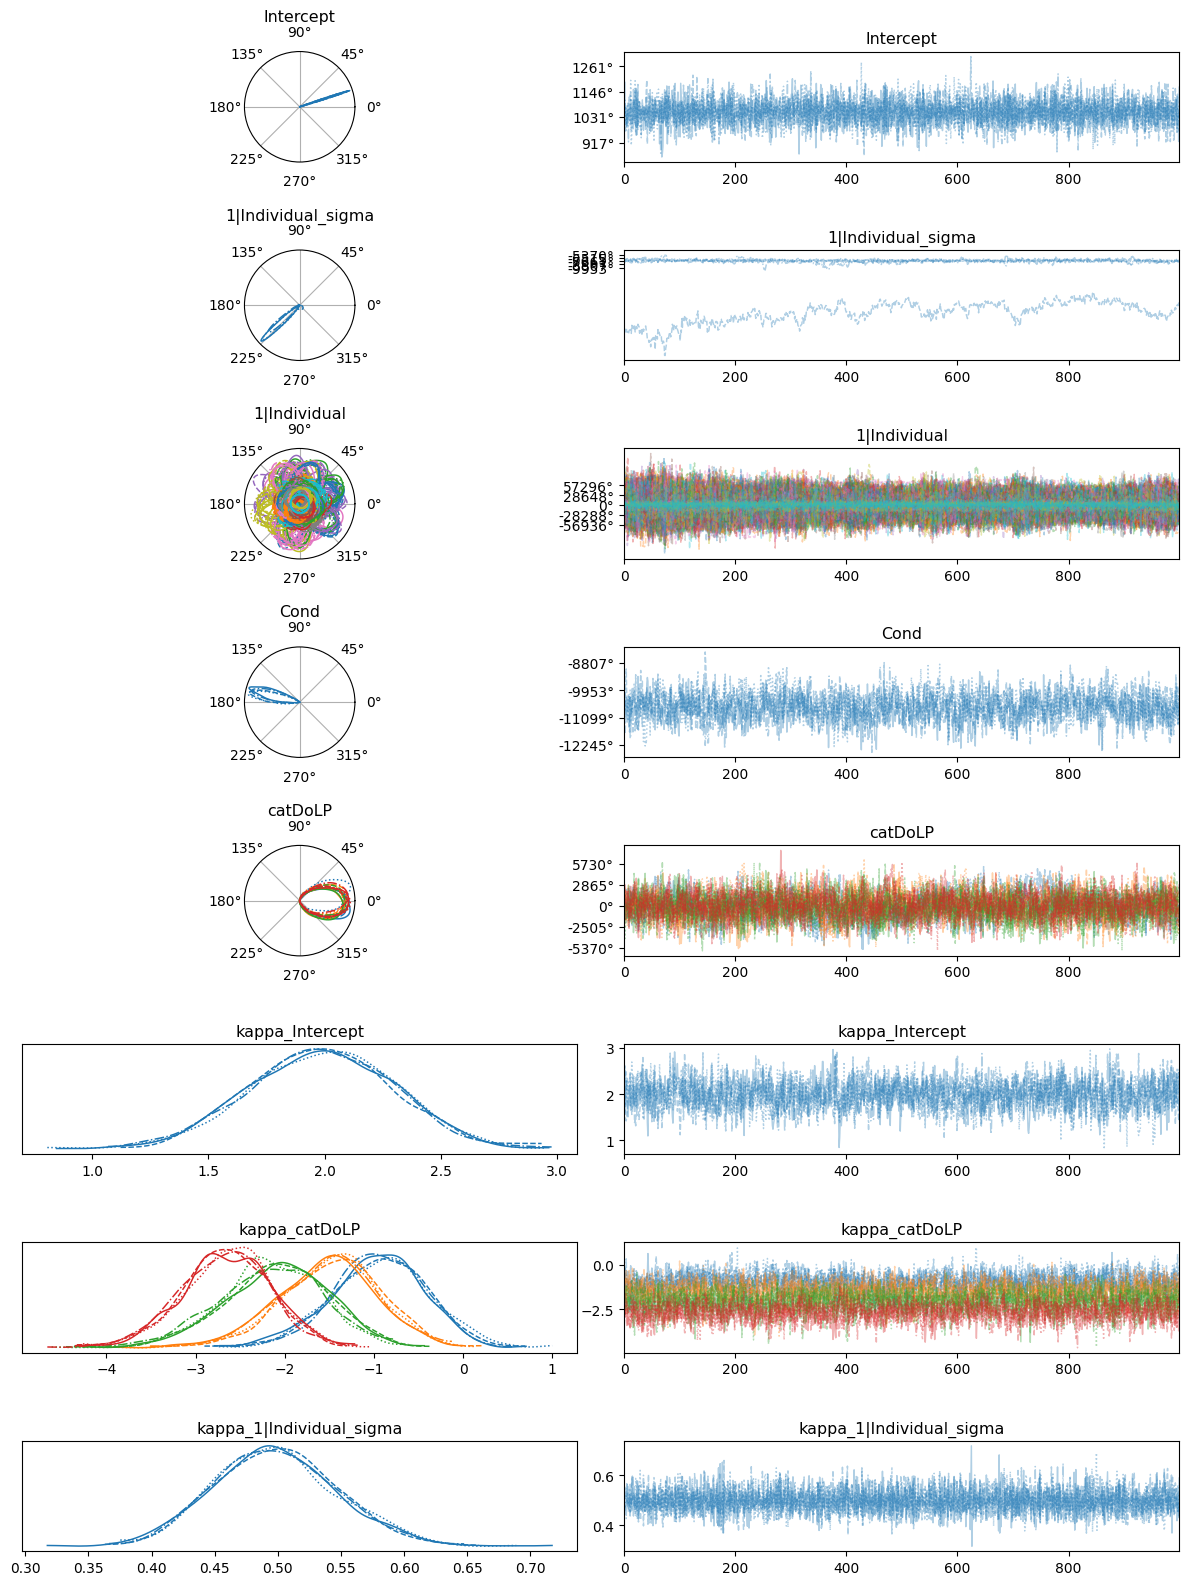

In [ ]:
cat_varnms = ["Intercept",
            #    "1|Individual_kappa",
               "1|Individual_sigma",
               "1|Individual",
                "Cond",
                "catDoLP",
                "kappa_Intercept",
                "kappa_catDoLP",
               "kappa_1|Individual_sigma",
                ]
#Specify which parameters are circular
cat_cvars = ["Intercept",
             "1|Individual",
             #  "1|Individual_sigma", # fun to plot on a circular scale, but hard to identify problems
                    "Cond",
                    "catDoLP",
        ]
#transform the circular data for interpretability
cat_idata_trans = cat_idata.copy() # set up a variable for transformed data #20250327 somehow linked to old variable!
for cvar in cat_cvars:
    cat_idata_trans.posterior[cvar] = -180*cat_idata.posterior[cvar]/np.pi # convert each to degrees that will plot clockwise

az.plot_trace(cat_idata_trans,
              var_names=cat_varnms,
              circ_var_names=cat_cvars,
              circ_var_units='degrees'
              ) #now in degrees and going clockwise, but axis labels are anticlock and start at right
plt.tight_layout()
plt.show()

# Model with linear effect of (negative) DoLP

In [77]:
#help with progressbar on Mac?
# https://discourse.pymc.io/t/progress-bar-not-showing-in-pymc3-3-11-1/6898/4
from fastprogress import fastprogress
fastprogress.printing = lambda: True
import numpy as np
import pandas as pd
import bambi as bmb
import arviz as az
import matplotlib.pyplot as plt

from unwrap.link.bambi import LINKS
from unwrap.link.numpy import inverse_softplus
from pymc import VonMises

from scipy.stats import vonmises, circstd


#1st test, doubled angles as in Foster et al., 2019
df['TwoAngle'] = df['RadAngle'].apply(lambda x: shifted_modulo(x*2) if pd.notnull(x) else x)

#2nd test, inverse DoLP so that 0 == maximum kappa (potentially easier intercept condition)
df['invDoLP'] = df['DoLP'].apply(lambda x: -(1-x)) #intention: 0.99 -> -0.01; 0.02 -> -0.98
#1st test, condition as a categorical 
df['Cond'] = df['PolAngle_rad'].astype('category')
# Use MLE estimates of one condition to find good priors for individual effects (each represents one trial per animal)
condata = df[df['Cond'] == 0 ] #just the data for polarizer to the North, expect a change of +-90° (x2 = 180°) for polarizer East
vm_prior = vonmises.fit(condata["TwoAngle"], fscale=1) #MLE von Mises fit to dist of individuals
sd_prior = circstd(condata["TwoAngle"]) #Mardia SD used as estimate of normal SD

# Define the model formula with updated, capitalized variable names.
neg_formula = bmb.Formula(
    "TwoAngle ~ Cond + invDoLP + (1|Individual)",
    "kappa ~ invDoLP + (1|Individual)",
)

# Specify priors for the model with capitalized keys and updated variable names.
#20250327 a lot of divergences and high rhats, but fixed with normal prior on individual directions
# 2 trials per individual may be insufficient to estimate individual effects in this way
neg_priors = {
    # Fixed effects for μ:
    # It is difficult to find the mean of uniformly distributed individual headings, may be better to anchor it
    # Normal version converges smoother
    "Intercept": bmb.Prior("Normal", mu=vm_prior[1], sigma=1*np.pi/180), 
    # We expect the effect of condition to be a change of 180° (2 x 90°), most priors find this fairly well
    "Cond": bmb.Prior("Normal", mu=np.pi, sigma=60*np.pi/180), #
    # No expectations about different mean headings by DoLP, beyond a wider spread
    "invDoLP": bmb.Prior("Normal", mu=0, sigma=30*np.pi/180), #could be wider, as 1.0 includes the entire range of DoLP
    # Individual-level effects for μ: #bias to high kappa appears to cause divergent transitions here
    "1|Individual": bmb.Prior(
    # In these experiments, we have no expectation that beetles would choose the same direction in their 1st trial
    # 20250328 noticed multimodality in the posterior, much larger option also found. Try less restrictive?
    # Informative prior used expecting SD close to that measured empirically
    # Using a normal distribution because that converges better
    # "Normal", mu=0, sigma=bmb.Prior("StudentT", nu = 3, mu=sd_prior, sigma = 0.2) #assume the ML estimate is correct
    "Normal", mu=0, sigma=bmb.Prior("LogNormal", mu=np.log(sd_prior), sigma=0.07) #assume the ML estimate is correct
    ),
    # Priors for the κ-model (inside the "kappa" dictionary):
    "kappa": {
        # Fixed effects for κ:
        # # Across two trials the MLE for this should range from ≈1.5–2.8
        #20250327 try higher precision to make individual mean directions easier to estimate
        "Intercept": bmb.Prior("Normal", mu=inverse_softplus(10), sigma=1.0), 
        "invDoLP": bmb.Prior("Normal", mu=0, sigma=1.0), 
        # Individual-level effects for κ:
        "1|Individual": bmb.Prior(
            "Normal", mu=0, sigma=bmb.Prior("LogNormal", mu=np.log(0.5), sigma=0.1) #Informative prior, individual differences in concentration are small
        ),
    },
}

# Build the model using the updated formula and priors.
neg_model = bmb.Model(
    neg_formula,
    df,
    family="vonmises",
    priors=neg_priors,
    link={"mu": LINKS["shifted_modulo"], "kappa": LINKS["softplus"]},
    center_predictors=False,
    dropna=True,
    
)

print(neg_model)

# Fit the model.
# 4000 iterations takes approx 180s
neg_idata = neg_model.fit(
                draws= 1000,
                tune = 1000,
                init = 'auto',
                progressbar=True) # 

       Formula: TwoAngle ~ Cond + invDoLP + (1|Individual)
                kappa ~ invDoLP + (1|Individual)
        Family: vonmises
          Link: mu = shifted_modulo
                kappa = softplus
  Observations: 680
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: -0.3222, sigma: 0.0175)
            Cond ~ Normal(mu: 3.1416, sigma: 1.0472)
            invDoLP ~ Normal(mu: 0.0, sigma: 0.5236)
        
        Group-level effects
            1|Individual ~ Normal(mu: 0.0, sigma: LogNormal(mu: 0.869, sigma: 0.07))
    target = kappa
        Common-level effects
            kappa_Intercept ~ Normal(mu: 10.0, sigma: 1.0)
            kappa_invDoLP ~ Normal(mu: 0.0, sigma: 1.0)
        
        Group-level effects
            kappa_1|Individual ~ Normal(mu: 0.0, sigma: LogNormal(mu: -0.6931, sigma: 0.1))


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, Cond, invDoLP, 1|Individual_sigma, 1|Individual_offset, kappa_Intercept, kappa_invDoLP, kappa_1|Individual_sigma, kappa_1|Individual_offset]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 77 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


## Check convergence heuristics
We expect an intercept kappa of around 3 and a coefficient for `invDoLP` > 3, which would suggest that with a decrease in DoLP of 1.0 _kappa_ begins to approach zero. In practice with 2 trials it is difficult to measure _kappa_ = `0`. In the original publication, _kappa_ was estimated to be approximately `0.2` for DoLP of `0.0`.

In [78]:
#check convergence heuristics
#It may not even make sense to try to converge the model without the interaction, since the mu effect  brightness depends strongly on colour
az.summary(
    neg_idata, 
    var_names=["Intercept",
            #    "1|Individual_kappa",
               "1|Individual_sigma",
                "Cond",
                "invDoLP",
                "kappa_Intercept",
                "kappa_invDoLP",
               "kappa_1|Individual_sigma",
                ],
    circ_var_names=["Intercept",
                    "Cond",
                    "invDoLP",
                    ]
)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Intercept                -0.322  0.017  -0.353   -0.291      0.000    0.000   
1|Individual_sigma        2.524  0.168   2.200    2.825      0.043    0.031   
Cond[1.5707963267948966] -2.846  0.153   3.139   -2.571      0.012    0.008   
invDoLP                  -0.077  0.529  -1.027    0.929      0.028    0.026   
kappa_Intercept           2.694  0.386   1.948    3.379      0.010    0.007   
kappa_invDoLP             3.303  0.497   2.349    4.201      0.014    0.010   
kappa_1|Individual_sigma  0.503  0.051   0.407    0.596      0.001    0.000   

                          ess_bulk  ess_tail  r_hat  
Intercept                   5618.0    2634.0   1.00  
1|Individual_sigma            16.0     111.0   1.18  
Cond[1.5707963267948966]     185.0    1174.0   1.02  
invDoLP                      209.0     489.0   1.01  
kappa_Intercept             1564.0    1981.0   1.01  
kappa_invDoLP               1287.0    1880.0   1.01  
kappa_1|Individual_sigma    7698.0    3012.0   1.00

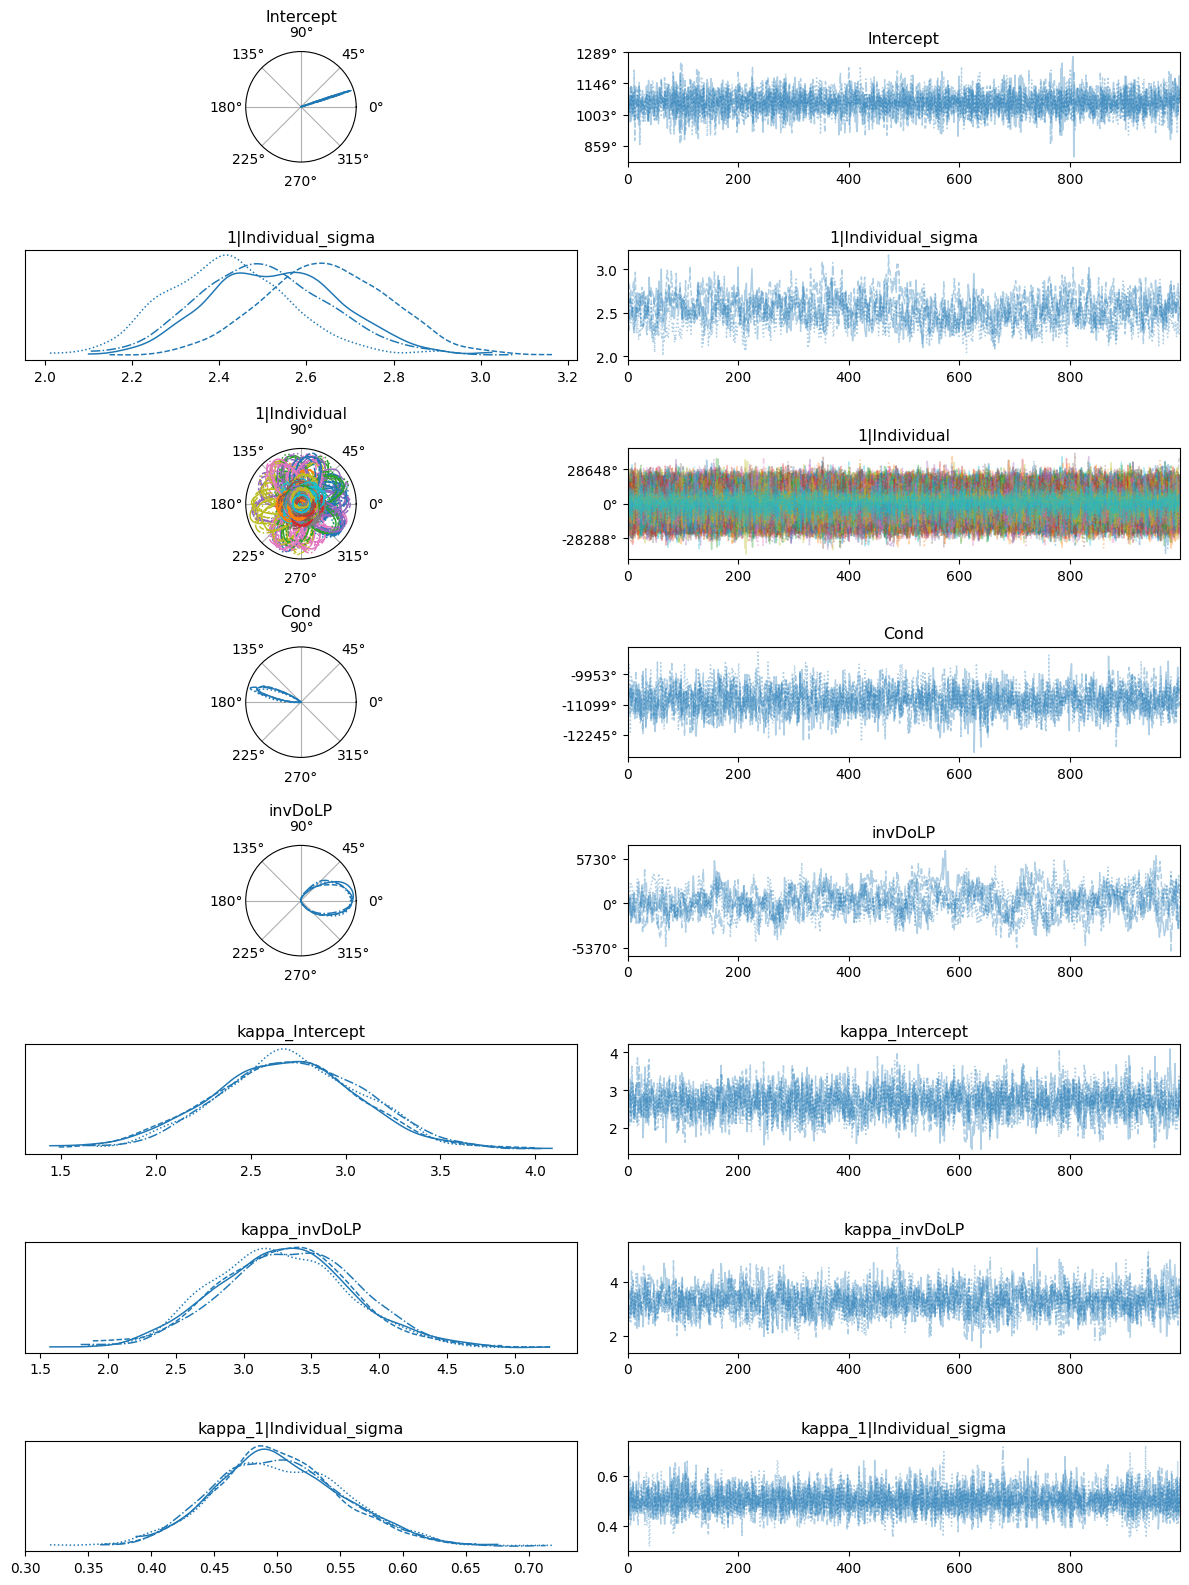

In [79]:
neg_varnms = ["Intercept",
            #    "1|Individual_kappa",
               "1|Individual_sigma",
               "1|Individual",
                "Cond",
                "invDoLP",
                "kappa_Intercept",
                "kappa_invDoLP",
               "kappa_1|Individual_sigma",
                ]
#Specify which parameters are circular
neg_cvars = ["Intercept",
             "1|Individual",
            #  "1|Individual_sigma", # fun to plot on a circular scale, but hard to identify problems
                    "Cond",
                    "invDoLP",
        ]
#transform the circular data for interpretability
neg_idata_trans = neg_idata.copy() # set up a variable for transformed data #20250327 somehow linked to old variable!
for cvar in neg_cvars:
    neg_idata_trans.posterior[cvar] = -180*neg_idata.posterior[cvar]/np.pi # convert each to degrees that will plot clockwise

az.plot_trace(neg_idata_trans,
              var_names=neg_varnms,
              circ_var_names=neg_cvars,
              circ_var_units='degrees'
              ) #now in degrees and going clockwise, but axis labels are anticlock and start at right
plt.tight_layout()
plt.show()

# Model with linear effect of logarithmic-scaled DoLP on doubled angles

In [70]:
#help with progressbar on Mac?
# https://discourse.pymc.io/t/progress-bar-not-showing-in-pymc3-3-11-1/6898/4
from fastprogress import fastprogress
fastprogress.printing = lambda: True
import numpy as np
import pandas as pd
import bambi as bmb
import arviz as az
import matplotlib.pyplot as plt

from unwrap.link.bambi import LINKS
from unwrap.link.numpy import inverse_softplus
from pymc import VonMises

from scipy.stats import vonmises, circstd


#1st test, doubled angles as in Foster et al., 2019
df['TwoAngle'] = df['RadAngle'].apply(lambda x: shifted_modulo(x*2) if pd.notnull(x) else x)

#2nd test, inverse DoLP so that 0 == maximum kappa (potentially easier intercept condition)
df['l10DoLP'] = df['DoLP'].apply(lambda x: np.log10(x)) #intention: 0.99 -> -0.01; 0.02 -> -0.98
#1st test, condition as a categorical 
df['Cond'] = df['PolAngle_rad'].astype('category')
# Use MLE estimates of one condition to find good priors for individual effects (each represents one trial per animal)
condata = df[df['Cond'] == 0 ] #just the data for polarizer to the North, expect a change of +-90° (x2 = 180°) for polarizer East
vm_prior = vonmises.fit(condata["TwoAngle"], fscale=1) #MLE von Mises fit to dist of individuals
sd_prior = circstd(condata["TwoAngle"]) #Mardia SD used as estimate of normal SD

# Define the model formula with updated, capitalized variable names.
log_formula = bmb.Formula(
    "TwoAngle ~ Cond + l10DoLP + (1|Individual)",
    "kappa ~ l10DoLP + (1|Individual)",
)

# Specify priors for the model with capitalized keys and updated variable names.
#20250327 a lot of divergences and high rhats, but fixed with normal prior on individual directions
# 2 trials per individual may be insufficient to estimate individual effects in this way
log_priors = {
    # Fixed effects for μ:
    # It is difficult to find the mean of uniformly distributed individual headings, may be better to anchor it
    # Normal version converges smoother
    "Intercept": bmb.Prior("Normal", mu=vm_prior[1], sigma=1*np.pi/180), 
    # We expect the effect of condition to be a change of 180° (2 x 90°), most priors find this fairly well
    "Cond": bmb.Prior("Normal", mu=np.pi, sigma=60*np.pi/180), #
    # No expectations about different mean headings by DoLP, beyond a wider spread
    "l10DoLP": bmb.Prior("Normal", mu=0, sigma=30*np.pi/180), #could be wider, as 1.0 includes the entire range of DoLP
    # Individual-level effects for μ: #bias to high kappa appears to cause divergent transitions here
    "1|Individual": bmb.Prior(
    # In these experiments, we have no expectation that beetles would choose the same direction in their 1st trial
    # 20250328 noticed multimodality in the posterior, much larger option also found. Try less restrictive?
    # Informative prior used expecting SD close to that measured empirically
    # Using a normal distribution because that converges better
    # "Normal", mu=0, sigma=bmb.Prior("StudentT", nu = 3, mu=sd_prior, sigma = 0.07) #This causes the most problems
    "Normal", mu=0, sigma=bmb.Prior("LogNormal", mu=np.log(sd_prior), sigma=0.05) #assume the ML estimate is correct
    ),
    # Priors for the κ-model (inside the "kappa" dictionary):
    "kappa": {
        # Fixed effects for κ:
        # # Across two trials the MLE for this should range from ≈1.5–2.8
        "Intercept": bmb.Prior("Normal", mu=inverse_softplus(10), sigma=1.0), 
        #conveniently log10(DoLP == 1.0) = 0.0, so the maximum polarization is the intercept condition
        "l10DoLP": bmb.Prior("Normal", mu=0, sigma=1.0), 
        # Individual-level effects for κ:
        "1|Individual": bmb.Prior(
            "Normal", mu=0, sigma=bmb.Prior("LogNormal", mu=np.log(0.5), sigma=0.1) #Informative prior, individual differences in concentration are small
        ),
    },
}

# Build the model using the updated formula and priors.
log_model = bmb.Model(
    log_formula,
    df,
    family="vonmises",
    priors=log_priors,
    link={"mu": LINKS["shifted_modulo"], "kappa": LINKS["softplus"]},
    center_predictors=False,
    dropna=True,
    
)

print(log_model)

# Fit the model.
# 4000 iterations takes approx 180s
log_idata = log_model.fit(
                draws= 1000,
                tune = 1000,
                init = 'auto',
                progressbar=True) # 

       Formula: TwoAngle ~ Cond + l10DoLP + (1|Individual)
                kappa ~ l10DoLP + (1|Individual)
        Family: vonmises
          Link: mu = shifted_modulo
                kappa = softplus
  Observations: 680
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: -0.3222, sigma: 0.0175)
            Cond ~ Normal(mu: 3.1416, sigma: 1.0472)
            l10DoLP ~ Normal(mu: 0.0, sigma: 0.5236)
        
        Group-level effects
            1|Individual ~ Normal(mu: 0.0, sigma: LogNormal(mu: 0.869, sigma: 0.05))
    target = kappa
        Common-level effects
            kappa_Intercept ~ Normal(mu: 10.0, sigma: 1.0)
            kappa_l10DoLP ~ Normal(mu: 0.0, sigma: 1.0)
        
        Group-level effects
            kappa_1|Individual ~ Normal(mu: 0.0, sigma: LogNormal(mu: -0.6931, sigma: 0.1))


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, Cond, l10DoLP, 1|Individual_sigma, 1|Individual_offset, kappa_Intercept, kappa_l10DoLP, kappa_1|Individual_sigma, kappa_1|Individual_offset]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 73 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


## Check convergence heuristics

In [71]:
#check convergence heuristics
#It may not even make sense to try to converge the model without the interaction, since the mu effect  brightness depends strongly on colour
az.summary(
    log_idata, 
    var_names=["Intercept",
            #    "1|Individual_kappa",
               "1|Individual_sigma",
                "Cond",
                "l10DoLP",
                "kappa_Intercept",
                "kappa_l10DoLP",
               "kappa_1|Individual_sigma",
                ],
    circ_var_names=["Intercept",
                    "Cond",
                    "l10DoLP",
                    ]
)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Intercept                -0.322  0.017  -0.356   -0.291      0.000    0.000   
1|Individual_sigma        2.439  0.113   2.232    2.653      0.017    0.012   
Cond[1.5707963267948966] -2.947  0.143   3.053   -2.696      0.006    0.004   
l10DoLP                   0.008  0.515  -0.930    0.992      0.051    0.029   
kappa_Intercept           2.634  0.347   2.004    3.300      0.008    0.006   
kappa_l10DoLP             2.629  0.496   1.724    3.568      0.015    0.011   
kappa_1|Individual_sigma  0.504  0.051   0.410    0.598      0.001    0.000   

                          ess_bulk  ess_tail  r_hat  
Intercept                   6161.0    2917.0   1.00  
1|Individual_sigma            43.0     905.0   1.07  
Cond[1.5707963267948966]     825.0    2242.0   1.01  
l10DoLP                      164.0     627.0   1.03  
kappa_Intercept             1924.0    2336.0   1.00  
kappa_l10DoLP               1060.0    2036.0   1.00  
kappa_1|Individual_sigma    5749.0    2577.0   1.00

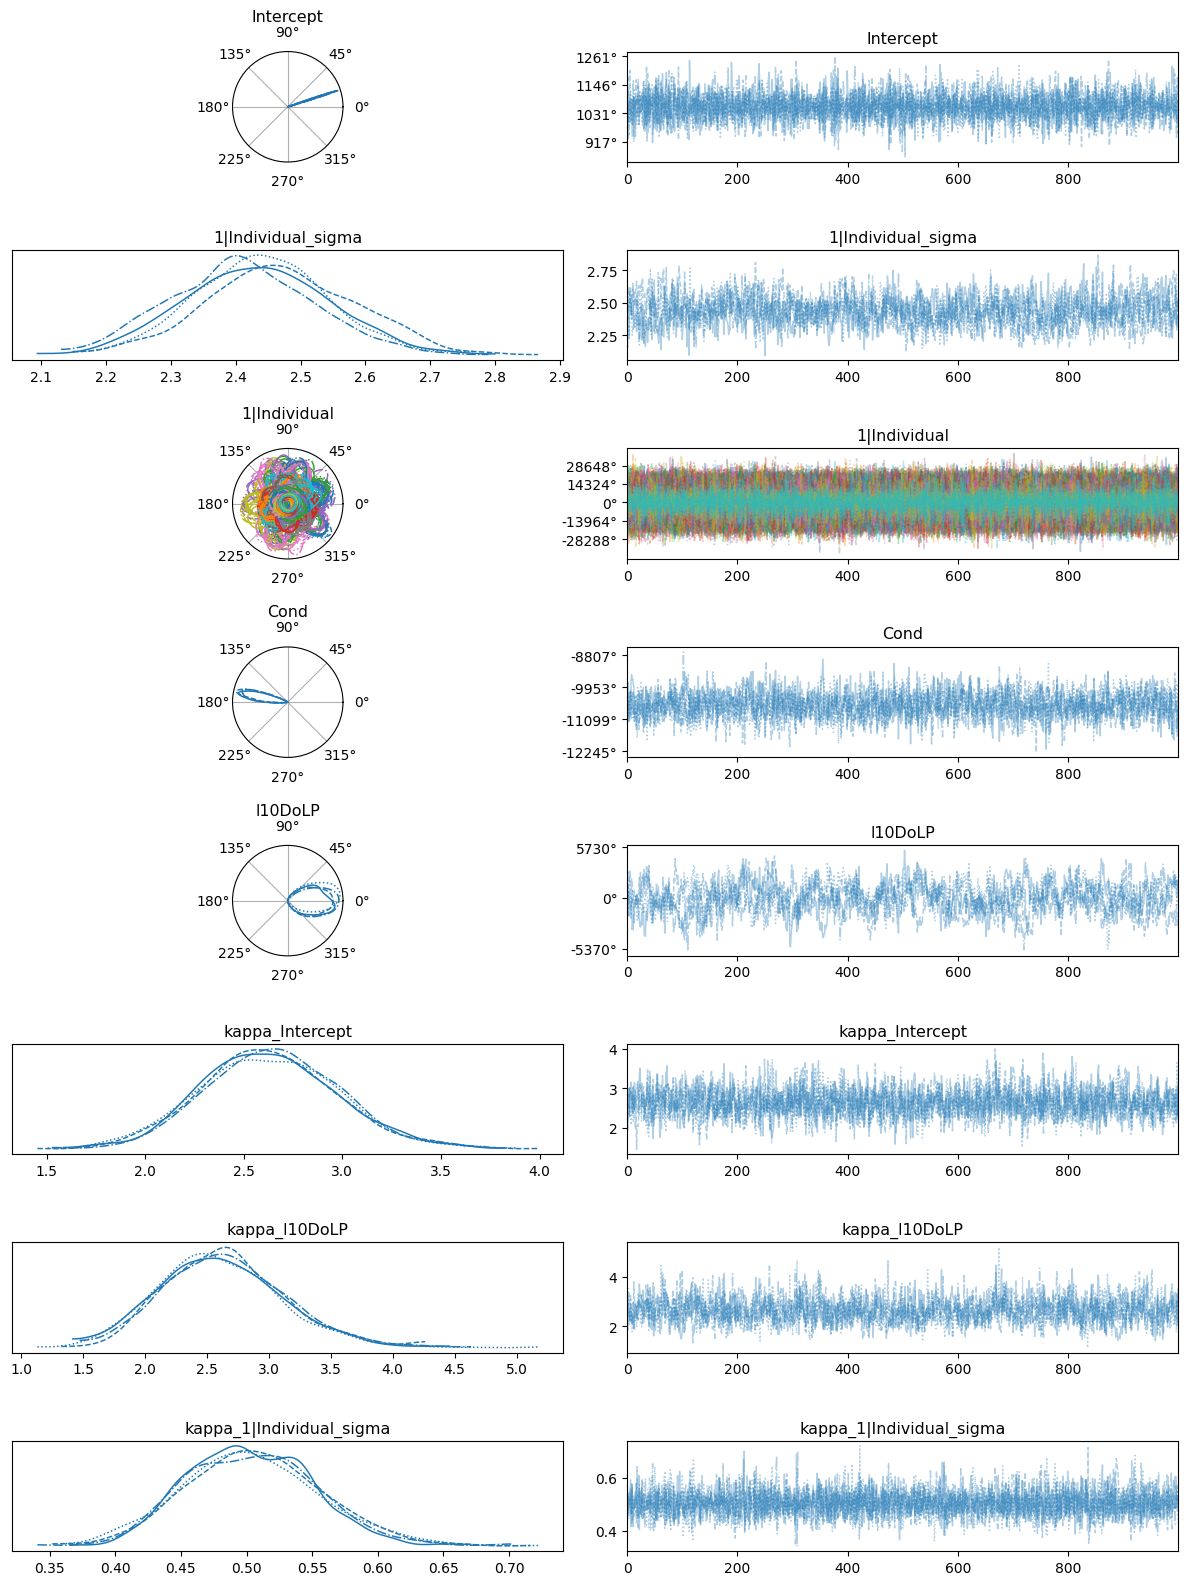

In [72]:
log_varnms = ["Intercept",
            #    "1|Individual_kappa",
               "1|Individual_sigma",
               "1|Individual",
                "Cond",
                "l10DoLP",
                "kappa_Intercept",
                "kappa_l10DoLP",
               "kappa_1|Individual_sigma",
                ]
#Specify which parameters are circular
log_cvars = ["Intercept",
             "1|Individual",
            #  "1|Individual_sigma", # fun to view on circular scale, as is an angle but not periodic
                    "Cond",
                    "l10DoLP",
        ]
#transform the circular data for interpretability
log_idata_trans = log_idata.copy() # set up a variable for transformed data #20250327 somehow linked to old variable!
for cvar in log_cvars:
    log_idata_trans.posterior[cvar] = -180*log_idata.posterior[cvar]/np.pi # convert each to degrees that will plot clockwise

az.plot_trace(log_idata_trans,
              var_names=log_varnms,
              circ_var_names=log_cvars,
              circ_var_units='degrees'
              ) #now in degrees and going clockwise, but axis labels are anticlock and start at right
plt.tight_layout()
plt.show()

# Model with linear effects on logit scaled DoLP

In [ ]:
#This model still needs some work!
#help with progressbar on Mac?
# https://discourse.pymc.io/t/progress-bar-not-showing-in-pymc3-3-11-1/6898/4
from fastprogress import fastprogress
fastprogress.printing = lambda: True
import numpy as np
import pandas as pd
import bambi as bmb
import arviz as az
import matplotlib.pyplot as plt

from unwrap.link.bambi import LINKS
from unwrap.link.numpy import inverse_softplus
from pymc import VonMises

from scipy.stats import vonmises, circstd
from scipy.special import logit


#1st test, doubled angles as in Foster et al., 2019
df['TwoAngle'] = df['RadAngle'].apply(lambda x: shifted_modulo(x*2) if pd.notnull(x) else x)

#3rd test, logit DoLP +c so that 0 == maximum kappa (potentially easier intercept condition)
# df['logitDoLP'] = df['DoLP'].apply(lambda x: logit(x)-4.6) #intention: 0.99 -> -0.005; 0.02 -> -8.49
df['logitDoLP'] = df['DoLP'].apply(lambda x: logit(x)) #Using raw logit it much cleaner!
#1st test, condition as a categorical 
df['Cond'] = df['PolAngle_rad'].astype('category')
# Use MLE estimates of one condition to find good priors for individual effects (each represents one trial per animal)
condata = df[df['Cond'] == 0 ] #just the data for polarizer to the North, expect a change of +-90° (x2 = 180°) for polarizer East
vm_prior = vonmises.fit(condata["TwoAngle"], fscale=1) #MLE von Mises fit to dist of individuals
sd_prior = circstd(condata["TwoAngle"]) #Mardia SD used as estimate of normal SD

# Define the model formula with updated, capitalized variable names.
lgt_formula = bmb.Formula(
    "TwoAngle ~ Cond + catDoLP + (1|Individual)",
    "kappa ~ logitDoLP + (1|Individual)",
)

# Specify priors for the model with capitalized keys and updated variable names.
#20250327 a lot of divergences and high rhats, but fixed with normal prior on individual directions
# 2 trials per individual may be insufficient to estimate individual effects in this way
lgt_priors = {
    # Fixed effects for μ:
    # It is difficult to find the mean of uniformly distributed individual headings, may be better to anchor it
    # Normal version converges smoother
    "Intercept": bmb.Prior("Normal", mu=vm_prior[1], sigma=1*np.pi/180), #widened to reduce divergences
    # We expect the effect of condition to be a change of 180° (2 x 90°), most priors find this fairly well
    "Cond": bmb.Prior("Normal", mu=np.pi, sigma=60*np.pi/180), #
    # No expectations about different mean headings by DoLP, beyond a wider spread
    "catDoLP": bmb.Prior("Normal", mu=0, sigma=30*np.pi/180), #needs to be restricted for logit scale
    # Individual-level effects for μ: #bias to high kappa appears to cause divergent transitions here
    "1|Individual": bmb.Prior(
    # In these experiments, we have no expectation that beetles would choose the same direction in their 1st trial
    # 20250328 noticed multimodality in the posterior, much larger option also found. Try less restrictive?
    # Informative prior used expecting SD close to that measured empirically
    # Using a normal distribution because that converges better
    # "Normal", mu=0, sigma=bmb.Prior("StudentT", nu = 3, mu=sd_prior, sigma = 0.07) #allows negative!
    "Normal", mu=0, sigma=bmb.Prior("LogNormal", mu=np.log(sd_prior), sigma=0.07) #assume the ML estimate is correct
    ),
    # Priors for the κ-model (inside the "kappa" dictionary):
    "kappa": {
        # Fixed effects for κ:
        # # Across two trials the MLE for this should range from ≈1.5–2.8
        "Intercept": bmb.Prior("Normal", mu=inverse_softplus(10), sigma=1.0), 
        #conveniently log10(DoLP == 1.0) = 0.0, so the maximum polarization is the intercept condition
        "logitDoLP": bmb.Prior("Normal", mu=0, sigma=1.0), 
        # Individual-level effects for κ:
        "1|Individual": bmb.Prior(
            "Normal", mu=0, sigma=bmb.Prior("LogNormal", mu=np.log(0.5), sigma=0.1) #Informative prior, individual differences in concentration are small
        ),
    },
}

# Build the model using the updated formula and priors.
lgt_model = bmb.Model(
    lgt_formula,
    df,
    family="vonmises",
    priors=lgt_priors,
    link={"mu": LINKS["shifted_modulo"], "kappa": LINKS["softplus"]},
    center_predictors=False,
    dropna=True,
    
)

print(lgt_model)

# Fit the model.
# 4000 iterations takes approx 180s
lgt_idata = lgt_model.fit(
                draws= 1000,
                tune = 1000,
                init = 'auto',
                progressbar=True) # 

       Formula: TwoAngle ~ Cond + catDoLP + (1|Individual)
                kappa ~ logitDoLP + (1|Individual)
        Family: vonmises
          Link: mu = shifted_modulo
                kappa = softplus
  Observations: 680
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: -0.3222, sigma: 0.0175)
            Cond ~ Normal(mu: 3.1416, sigma: 1.0472)
            catDoLP ~ Normal(mu: 0.0, sigma: 0.5236)
        
        Group-level effects
            1|Individual ~ Normal(mu: 0.0, sigma: LogNormal(mu: 0.869, sigma: 0.07))
    target = kappa
        Common-level effects
            kappa_Intercept ~ Normal(mu: 10.0, sigma: 1.0)
            kappa_logitDoLP ~ Normal(mu: 0.0, sigma: 1.0)
        
        Group-level effects
            kappa_1|Individual ~ Normal(mu: 0.0, sigma: LogNormal(mu: -0.6931, sigma: 0.1))


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, Cond, catDoLP, 1|Individual_sigma, 1|Individual_offset, kappa_Intercept, kappa_logitDoLP, kappa_1|Individual_sigma, kappa_1|Individual_offset]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 78 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


## Check convergence heuristics

In [116]:
#check convergence heuristics
#It may not even make sense to try to converge the model without the interaction, since the mu effect  brightness depends strongly on colour
az.summary(
    lgt_idata, 
    var_names=["Intercept",
            #    "1|Individual_kappa",
               "1|Individual_sigma",
                "Cond",
                "catDoLP",
                "kappa_Intercept",
                "kappa_logitDoLP",
               "kappa_1|Individual_sigma",
                ],
    circ_var_names=["Intercept",
                    "Cond",
                    "catDoLP",
                    ]
)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Intercept                -0.322  0.017  -0.356   -0.290      0.000    0.000   
1|Individual_sigma        2.418  0.146   2.143    2.682      0.016    0.011   
Cond[1.5707963267948966] -2.861  0.153   3.126   -2.588      0.010    0.004   
catDoLP[0.32]             0.005  0.512  -0.944    0.951      0.033    0.027   
catDoLP[0.11]             0.021  0.526  -0.969    1.014      0.009    0.017   
catDoLP[0.04]             0.085  0.529  -0.924    1.052      0.011    0.012   
catDoLP[0.02]             0.018  0.507  -0.963    0.929      0.026    0.019   
kappa_Intercept           0.953  0.237   0.503    1.392      0.007    0.005   
kappa_logitDoLP           0.365  0.069   0.238    0.493      0.002    0.001   
kappa_1|Individual_sigma  0.500  0.051   0.407    0.599      0.001    0.000   

                          ess_bulk  ess_tail  r_hat  
Intercept                   5793.0    2663.0   1.00  
1|Individual_sigma            94.0    1080.0   1.05  
Cond[1.5707963267948966]     797.0    2266.0   1.02  
catDoLP[0.32]                178.0     507.0   1.03  
catDoLP[0.11]                469.0    1266.0   1.00  
catDoLP[0.04]               1027.0    1832.0   1.00  
catDoLP[0.02]                370.0     957.0   1.03  
kappa_Intercept             1087.0    2262.0   1.00  
kappa_logitDoLP             1354.0    2379.0   1.00  
kappa_1|Individual_sigma    5891.0    3005.0   1.00

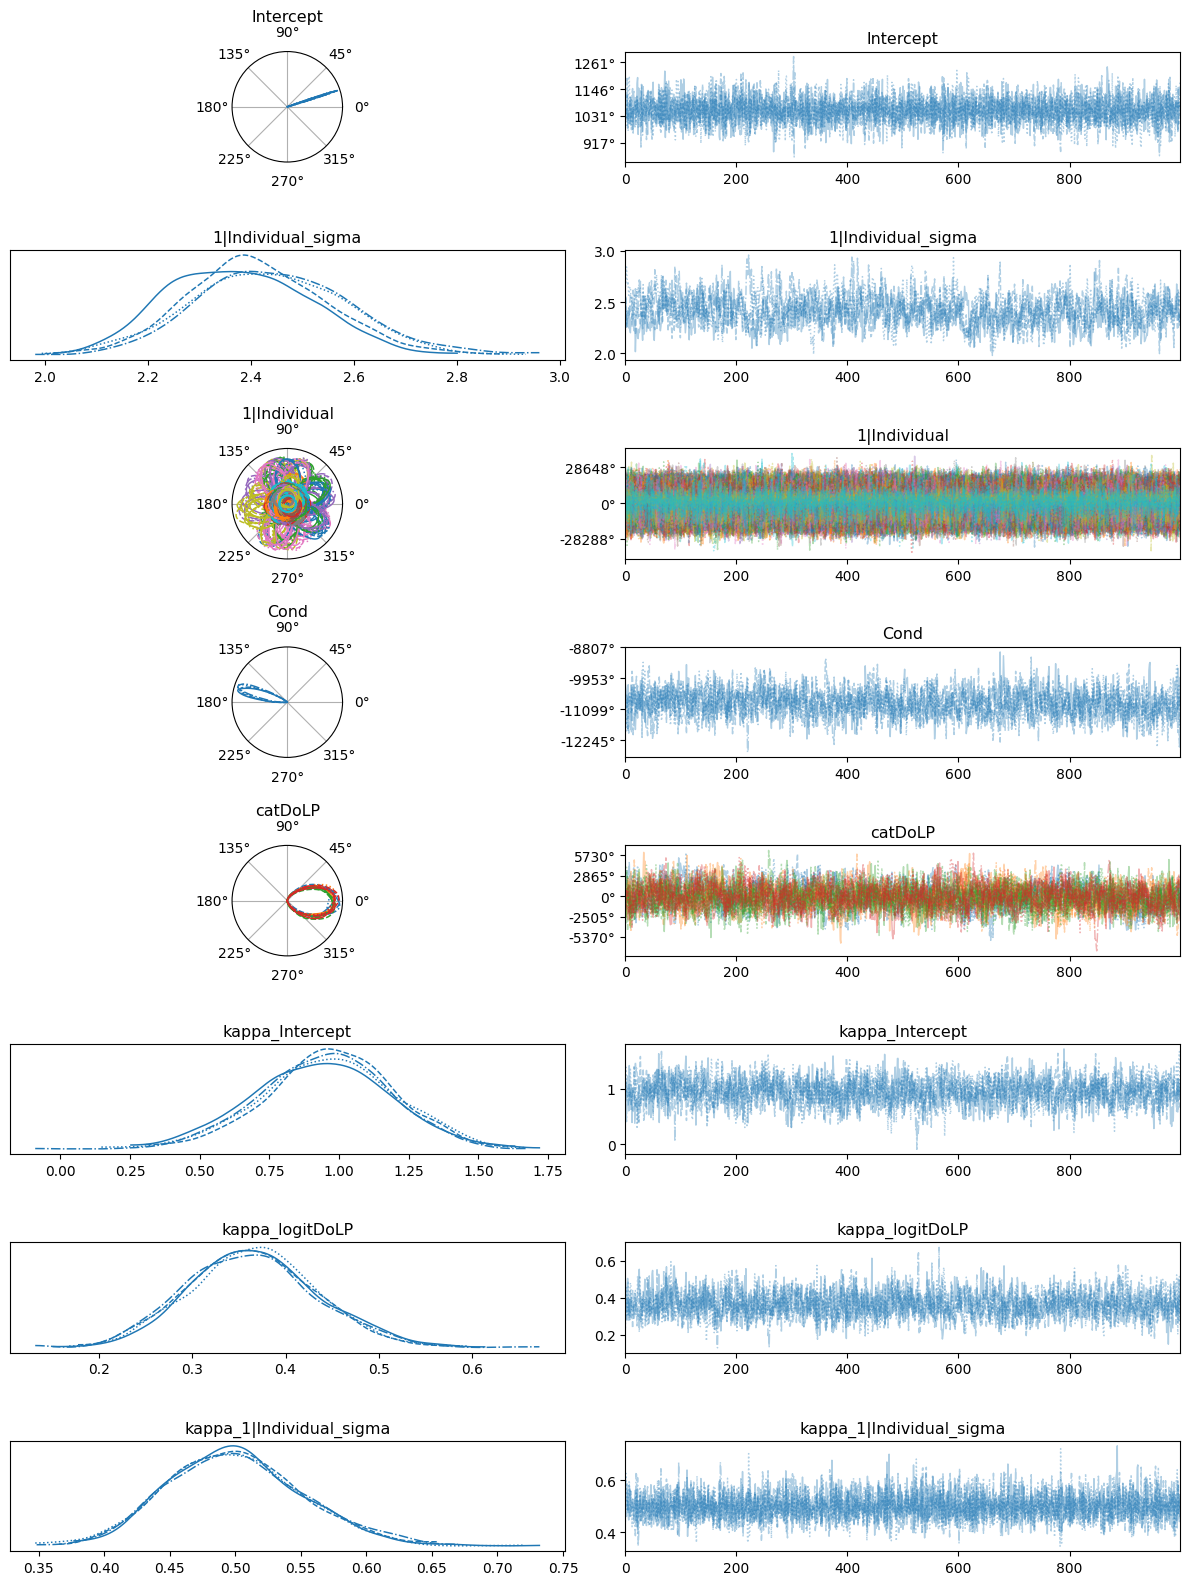

In [117]:
lgt_varnms = ["Intercept",
            #    "1|Individual_kappa",
               "1|Individual_sigma",
               "1|Individual",
                "Cond",
                "catDoLP",
                "kappa_Intercept",
                "kappa_logitDoLP",
               "kappa_1|Individual_sigma",
                ]
#Specify which parameters are circular
lgt_cvars = ["Intercept",
             "1|Individual",
            #  "1|Individual_sigma", # fun to view on circular scale, as is an angle but not periodic
                    "Cond",
                    "catDoLP",
        ]
#transform the circular data for interpretability
lgt_idata_trans = lgt_idata.copy() # set up a variable for transformed data #20250327 somehow linked to old variable!
for cvar in lgt_cvars:
    lgt_idata_trans.posterior[cvar] = -180*lgt_idata.posterior[cvar]/np.pi # convert each to degrees that will plot clockwise

az.plot_trace(lgt_idata_trans,
              var_names=lgt_varnms,
              circ_var_names=lgt_cvars,
              circ_var_units='degrees'
              ) #now in degrees and going clockwise, but axis labels are anticlock and start at right
plt.tight_layout()
plt.show()

# Compare Doubled-Angle models
Use leave-one-out cross validation (LOO-CV) to compare model predictions.

In [118]:
#First the log likelihood function needs to be computed for each model and dataset
cat_model.compute_log_likelihood(cat_idata)
neg_model.compute_log_likelihood(neg_idata)
log_model.compute_log_likelihood(log_idata)
lgt_model.compute_log_likelihood(lgt_idata)

#Calculate predictive power using LOO cross-validation
loo_cat = az.loo(cat_idata)
loo_neg = az.loo(neg_idata)
loo_log = az.loo(log_idata)
loo_lgt = az.loo(lgt_idata)

#print the results
print('\n----- Categorical -----\n')
print(loo_cat)
print('\n----- Linear -----\n')
print(loo_neg)
print('\n----- Logarithmic -----\n')
print(loo_log)
print('\n----- Logit scaled -----\n')
print(loo_lgt)
#some warnings in a small proportion of cases, but predictions are generally accurate

#compare, ranking models from best to worst
az.compare({'Categorical':loo_cat,
            'Linear':loo_neg,
            'Logarithmic':loo_log,
            'Logit scaled':loo_lgt}, 
            ic="loo")

C:\Users\James Foster\AppData\Roaming\Python\Python312\site-packages\arviz\stats\stats.py:792: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
C:\Users\James Foster\AppData\Roaming\Python\Python312\site-packages\arviz\stats\stats.py:792: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
C:\Users\James Foster\AppDat


----- Categorical -----

Computed from 4000 posterior samples and 680 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -1228.92     8.93
p_loo      171.04        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)      679   99.9%
   (0.70, 1]   (bad)         1    0.1%
   (1, Inf)   (very bad)    0    0.0%


----- Linear -----

Computed from 4000 posterior samples and 680 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -1230.22    10.00
p_loo      157.73        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)      677   99.6%
   (0.70, 1]   (bad)         3    0.4%
   (1, Inf)   (very bad)    0    0.0%


----- Logarithmic -----

Computed from 4000 posterior samples and 680 observations log-likel

C:\Users\James Foster\AppData\Roaming\Python\Python312\site-packages\arviz\stats\stats.py:792: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


rank     elpd_loo       p_loo  elpd_diff        weight  \
Logarithmic      0 -1225.866565  141.425703   0.000000  7.353704e-01   
Categorical      1 -1228.919324  171.041261   3.052759  1.858863e-01   
Linear           2 -1230.216125  157.730735   4.349560  7.874337e-02   
Logit scaled     3 -1230.829368  174.960890   4.962803  5.440093e-15   

                     se       dse  warning scale  
Logarithmic   10.755901  0.000000     True   log  
Categorical    8.930535  3.300454     True   log  
Linear         9.997440  3.461468     True   log  
Logit scaled  10.291674  3.022409     True   log